In [112]:
import pathlib, copy, re
from itertools import product
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.ticker as mtick
import seaborn as sns
from Bio import Phylo
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION, length_distributions
from elyawy.sparta import Msa
import raxml_parser

In [82]:
def prettify_stat(summary_statistic: str):
    summary_statistic = summary_statistic.replace("\n", "_")
    summary_statistic = summary_statistic.lower()
    summary_statistic = summary_statistic.split("_")
    summary_statistic[0] = summary_statistic[0].upper()
    return " ".join(summary_statistic)

In [83]:
def get_classification(current_path: pathlib.Path):
    classification = pd.read_csv(current_path / "epsilon.csv", index_col=0)
    classification = classification.fillna(0.0).astype('float')
    def get_max(x):
        sorted_x = x.sort_values(ascending=False)
        if len(sorted_x) == 1 or sorted_x[0] > sorted_x[1]:
            return sorted_x.index[0]
        if len(sorted_x) == 2 or sorted_x[1] > sorted_x[2]:
            return ",".join(sorted(sorted_x.index[:2]))
        return ",".join(sorted_x.index)
    classification = classification.apply(get_max, axis=0)["100"]
    return classification

In [85]:
def get_percentile_summary(sims_df, empirical_df):
    to_df = {}
    for sum_stat in filter(lambda x: "SS" in x, sims_df.columns):
        percentile = stats.percentileofscore(sims_df[sum_stat], empirical_df[sum_stat], kind="weak")
        stat_def = SUMSTATS_DEFINITION[sum_stat].replace("\n", "_")#.replace("_"," ").title()
        to_df[stat_def] =  [sum_stat, empirical_df[sum_stat], percentile]
    
    percentile_summary =  pd.DataFrame(to_df,index=["stat_id","empirical","percentile"]).T
    percentile_summary["retained"] = (percentile_summary.percentile.between(2.5,97.5)).astype(int)

    return percentile_summary

def get_percentile_summary_pretty(sims_df, empirical_df):
    to_df = {}
    for sum_stat in filter(lambda x: "SS" in x, sims_df.columns):
        percentile = stats.percentileofscore(sims_df[sum_stat], empirical_df[sum_stat], kind="weak")
        stat_def = SUMSTATS_DEFINITION[sum_stat].replace("\n", "_").replace("_"," ").title()
        to_df[stat_def] =  [sum_stat, empirical_df[sum_stat], percentile]

    percentile_summary =  pd.DataFrame(to_df,index=["stat_id","empirical","percentile"]).T
    percentile_summary["retained"] = (percentile_summary.percentile.between(2.5,97.5)).astype(int)

    return percentile_summary


In [86]:
def get_max_gap(msa: Msa):
    pattern = re.compile("\w+")
    max_gap = 0
    for seq in msa.get_seq_with_indels():
        new_max = len(max(pattern.split(seq)))
        max_gap = new_max if new_max > max_gap else max_gap
    return max_gap


In [87]:
def fetch_paths(current_path: pathlib.Path):
    if len( n := list(current_path.glob("*.tree"))) == 1:
        tree_path = n[0]

    if len( n := list(current_path.glob("*.fasta"))) == 1:
        msa_path = n[0]

    if tree_path is None or msa_path is None:
        print("no fasta or tree file")
        exit()
    return tree_path, msa_path

In [88]:
def get_retained_data(summary_df: pd.DataFrame):
    test_df = summary_df.T.reset_index(names="old_index")
    test_df.columns = test_df.iloc[0,:]
    test_df = test_df.drop(index=range(3), columns=["stat_id"]).reset_index(drop=True)
    missing_cols = set(SUMSTATS_DEFINITION).difference(test_df.columns) 
    missing_cols = list(set(SUMSTATS_DEFINITION).difference(test_df.columns))
    test_df[missing_cols] = None
    test_df = test_df[SUMSTATS_LIST]
    return test_df.values.tolist()[0]

In [48]:
# get empirical MSA
REMOTE_PATH = pathlib.Path("/run/user/1000/kio-fuse-jiBfjN/sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results_rerun/eggnog").resolve() # sys.argv[2]

# MAIN_PATH = pathlib.Path("../bigger_test").resolve() # sys.argv[2]
MAIN_PATH = REMOTE_PATH / "Tenericutes_3WUBT"

if not MAIN_PATH.exists():
    print("Did not load data")
    raise FileNotFoundError(MAIN_PATH)

TREE_PATH = None
MSA_PATH = None

if len( n := list(MAIN_PATH.glob("*.fasta"))) == 1:
    MSA_PATH = n[0]

if MSA_PATH is None:
    print("no fasta or tree file")
    exit()

empirical_msa = Msa(str(MSA_PATH))
empirical_sum_stats = empirical_msa.get_sum_stats()
empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))
print(empirical_sum_stats)
classification = get_classification(MAIN_PATH)
print(classification)
# fetch simulated top 10000
ADEQUACY_FILES = MAIN_PATH / "adequacy"
# all_sims = {i: pd.read_csv(ADEQUACY_FILES / f"{i}.csv").drop(columns="Unnamed: 0")   for i in length_distributions}
all_sims = pd.read_csv(ADEQUACY_FILES / f"{classification}.csv").drop(columns="Unnamed: 0")
percentile_summary = get_percentile_summary_pretty(all_sims, empirical_sum_stats )
sum(percentile_summary.retained)/len(percentile_summary)

{'SS_0': 3.4193548387096775, 'SS_1': 1055.0, 'SS_2': 1010.0, 'SS_3': 981.0, 'SS_4': 62.0, 'SS_5': 18.0, 'SS_6': 11.0, 'SS_7': 6.0, 'SS_8': 27.0, 'SS_9': 3.5135135135135136, 'SS_10': 37.0, 'SS_11': 10.0, 'SS_12': 1.0, 'SS_13': 2.0, 'SS_14': 2.0, 'SS_15': 0.0, 'SS_16': 3.0, 'SS_17': 1.0, 'SS_18': 1.0, 'SS_19': 1.0, 'SS_20': 10.0, 'SS_21': 1.0, 'SS_22': 5.0, 'SS_23': 933.0, 'SS_24': 72.0, 'SS_25': 10.0, 'SS_26': 40.0}
geometric


0.3333333333333333

Tenericutes_3WUBT_geometric_SS_1


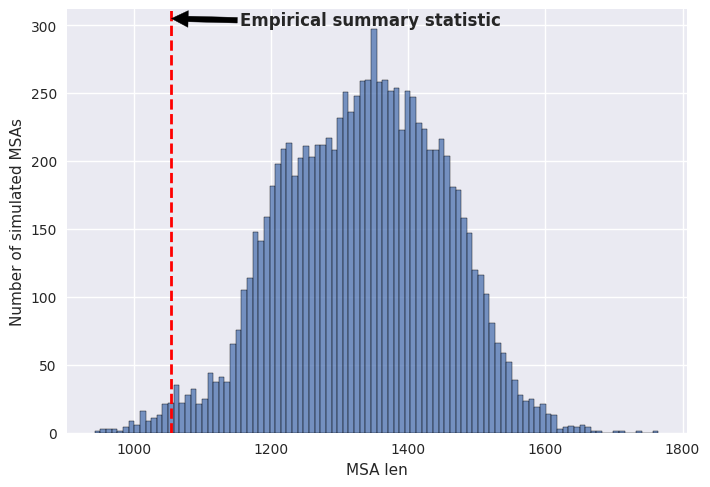

In [46]:
selected_stat = "SS_1"
# all_sims[selected_stat].hist(bins=100)
print(f"{MAIN_PATH.stem}_{classification}_{selected_stat}")
sns.histplot(all_sims[selected_stat], bins=100)
plt.xlabel(prettify_stat(SUMSTATS_DEFINITION[selected_stat]))
plt.ylabel("Number of simulated MSAs")
plt.axvline(x=empirical_sum_stats[selected_stat], linewidth=2, color='r', linestyle='--')
plt.annotate("Empirical summary statistic", xy=(empirical_sum_stats[selected_stat], 305), xytext=(empirical_sum_stats[selected_stat]+100, 300),
            arrowprops=dict(facecolor='black'), fontsize=12, fontweight="bold")
# plt.text(x=empirical_sum_stats[selected_stat]-50,y=300,s="$Empirical summary statisitic $")
plt.savefig(f"{MAIN_PATH.stem}_{classification}_{selected_stat}.svg",dpi=200)
# plt.show()

In [52]:
datasets = ["yeast", "eggnog"]
adequacy_data = {}
retained_summary_statistics_data = {}

for current_data in datasets:
    REMOTE_PATH = REMOTE_PATH.parent.resolve()
    REMOTE_PATH = REMOTE_PATH / current_data

    if not REMOTE_PATH.exists():
        exit(1)

    data_summary = {}
    retained_summary = {}

    for prot in REMOTE_PATH.iterdir():
        MAIN_PATH = prot
        TREE_PATH, MSA_PATH = fetch_paths(MAIN_PATH)

        
        try:
            model_params = raxml_parser.get_substitution_model(MAIN_PATH)
        except ValueError:
            print(MAIN_PATH.stem)
            model_params = {
                "inv_prop": -1,
                "gamma_shape": -1
            }

        
        tree = Phylo.read(TREE_PATH, 'newick')
        sum_branch_lengths = tree.total_branch_length()

        remote_emp_msa = Msa(str(MSA_PATH))
        empirical_sum_stats = remote_emp_msa.get_sum_stats()
        empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))

        classification = get_classification(MAIN_PATH)
        

        max_gap = get_max_gap(remote_emp_msa)

        ADEQUACY_FILES = MAIN_PATH / "adequacy" 
        classification_sims = pd.read_csv(ADEQUACY_FILES / f"{classification}.csv").drop(columns="Unnamed: 0")

        percentile_summary = get_percentile_summary(classification_sims, empirical_sum_stats)
        adequacy_score = sum(percentile_summary.retained)/len(percentile_summary)

        data_summary[prot.stem] = [max_gap, classification, adequacy_score, sum_branch_lengths, model_params["inv_prop"], model_params["gamma_shape"]]
        retained_summary[prot.stem] = [classification, *get_retained_data(percentile_summary)]

    adequacy_data[current_data] = pd.DataFrame(data_summary)
    adequacy_data[current_data] = adequacy_data[current_data].T.rename(columns={0:"max_gap", 
                                                                                1:"classification",
                                                                                2: "match_percent",
                                                                                3:"sum_branch_lengths",
                                                                                4: "inv_prop",
                                                                                5: "gamma_shape"})
    adequacy_data[current_data] = adequacy_data[current_data].astype({"max_gap": int,
                                                                      "match_percent": float,
                                                                      "sum_branch_lengths":float,
                                                                      "inv_prop": float,
                                                                      "gamma_shape": float})
    
    retained_summary_statistics_data[current_data] = retained_summary

Rhabditida_40V54
Rhabditida_40XMS
Rhabditida_410UG


In [92]:
import pickle

with open("retained_summary_statistics_data.pickle", 'rb') as f:
    retained_summary_statistics_data = pickle.load(f)

with open("adequacy_data.pickle", 'rb') as f:
    adequacy_data = pickle.load(f)


In [104]:
def plot_retained_stats(retained_dict: dict,dataset_name: str, subset: list):
    retained_summary_statistics_df = pd.DataFrame(retained_dict[dataset_name])
    retained_summary_statistics_df = retained_summary_statistics_df.T
    retained_summary_statistics_df = retained_summary_statistics_df[subset]
    retained_summary_statistics_df.columns = ["classification", *SUMSTATS_LIST]
    group_nas_sum = retained_summary_statistics_df.set_index("classification").isna().groupby(level=0).sum()
    group_sizes = retained_summary_statistics_df.groupby("classification").size()
    group_num_datasets_minus_number_of_nas = ((-group_nas_sum).add(group_sizes.squeeze(), axis=0))

    statistics_summary_df = retained_summary_statistics_df.groupby("classification").sum() / group_num_datasets_minus_number_of_nas
    statistics_summary_df = statistics_summary_df.dropna(axis=1, how="all")

    sum_retained_df = retained_summary_statistics_df.groupby("classification").sum()[statistics_summary_df.columns]#.drop("poisson", axis=1)
    sum_retained_df = sum_retained_df.T#.drop("poisson", axis=1)
    sum_retained_df.columns = ["size_" + col for col in sum_retained_df.columns]
    zipf_sizes = (max(sum_retained_df["size_zipf"].min(),5), sum_retained_df["size_zipf"].max())
    geometric_sizes = (max(sum_retained_df["size_geometric"].min(),5), sum_retained_df["size_geometric"].max())

    plot_df = pd.concat([statistics_summary_df.loc[["zipf","geometric"],:].T, sum_retained_df], axis=1)

    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams["figure.figsize"] = (15,5)

    sns.scatterplot(plot_df[["geometric","size_geometric"]].reset_index(),x='index', y='geometric', size="size_geometric", sizes=geometric_sizes, legend=False)
    sns.scatterplot(plot_df[["zipf","size_zipf"]].reset_index(),x='index', y='zipf', size="size_zipf", sizes=zipf_sizes)
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # statistics_summary_df.loc[["zipf","geometric"],:].T.plot(figsize=(15,5))
    plt.ylabel("")
    plt.xlabel("")

    plt.xticks(range(len(plot_df)), [prettify_stat(SUMSTATS_DEFINITION[stat]) for stat in plot_df.index], rotation=45, ha="right", size=16)

    plt.savefig(f"{dataset_name}_retained_summary.svg" ,dpi=200, bbox_inches="tight")
    plt.show()

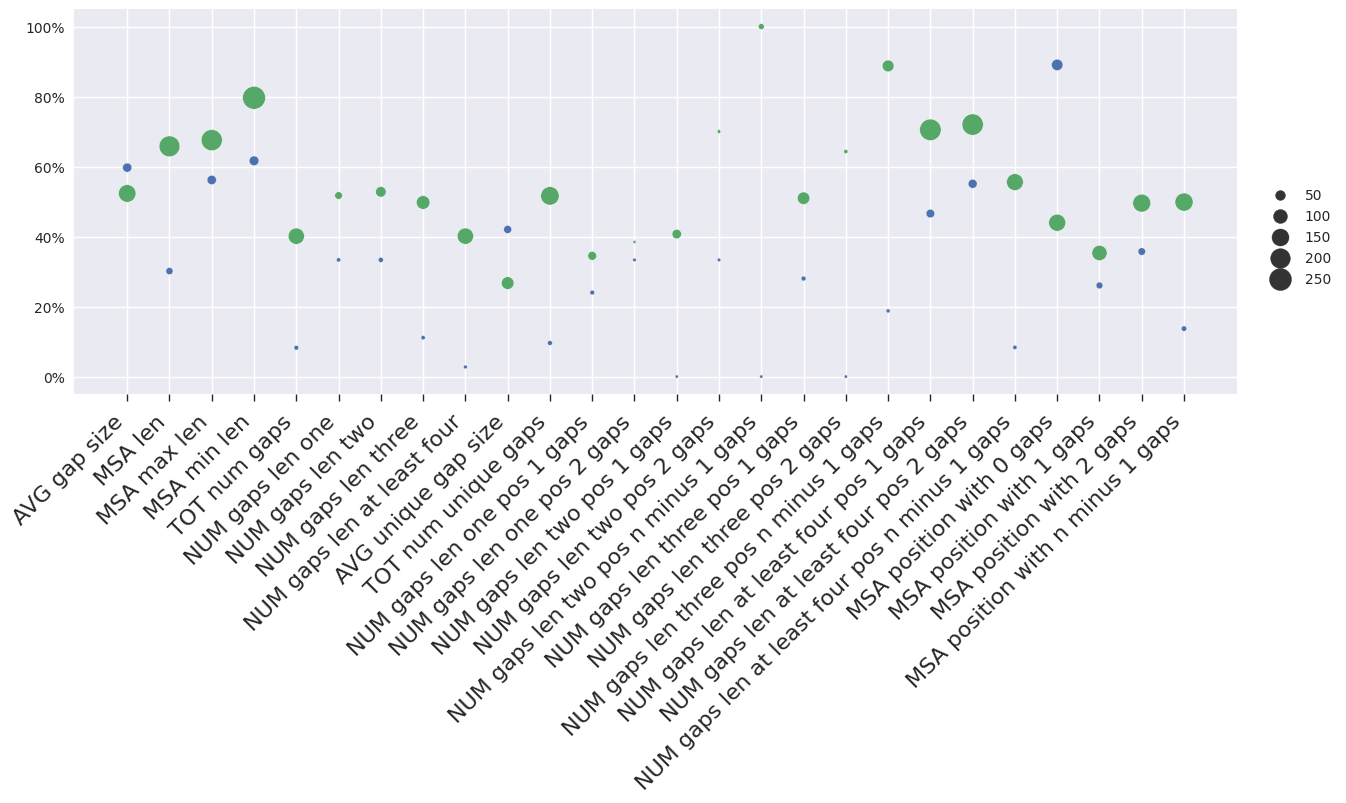

In [105]:
branch_length_filter = adequacy_data["eggnog"].sum_branch_lengths < 100
plot_retained_stats(retained_summary_statistics_data, "eggnog", branch_length_filter)

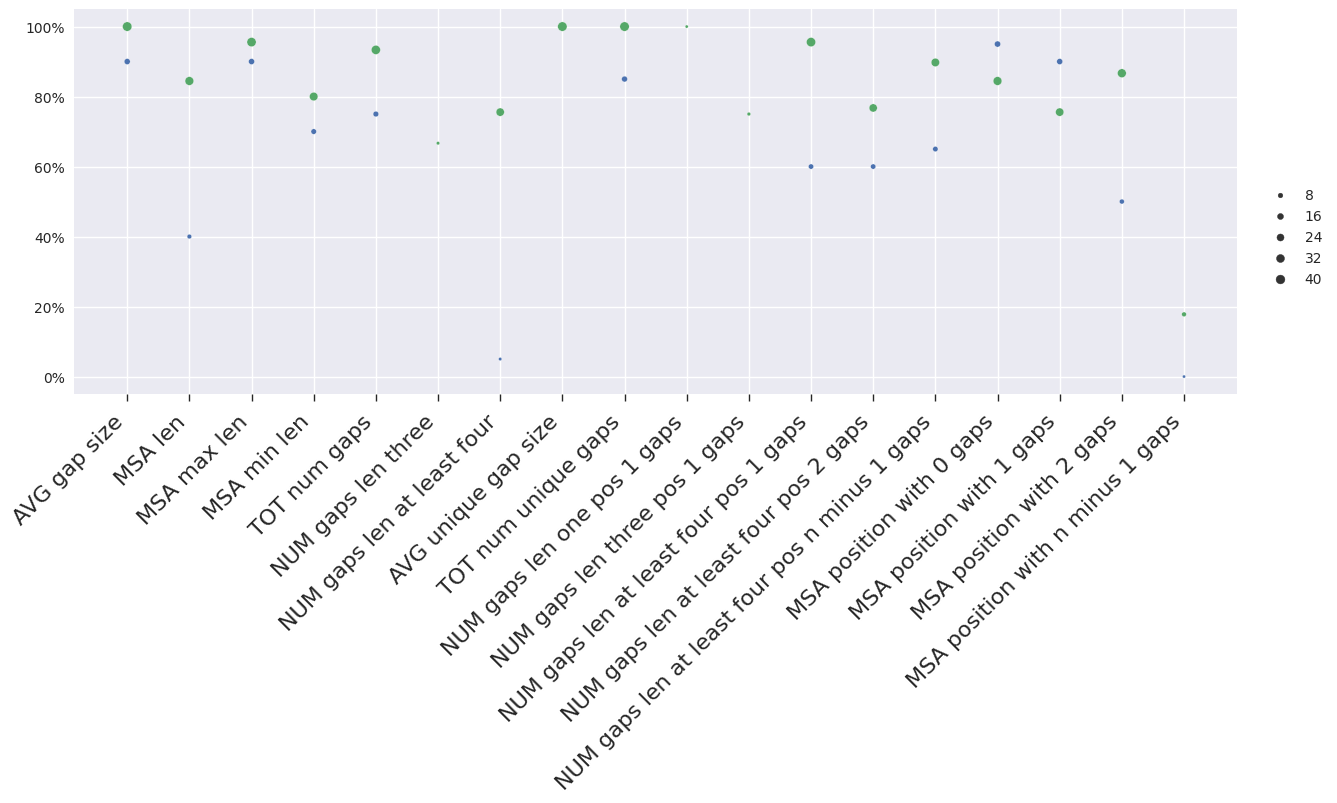

In [106]:
branch_length_filter = adequacy_data["yeast"].sum_branch_lengths < 100
plot_retained_stats(retained_summary_statistics_data, "yeast", branch_length_filter)

In [4]:
eggnog_limits = (adequacy_data["eggnog"]["sum_branch_lengths"].min(),adequacy_data["eggnog"]["sum_branch_lengths"].max())
print(eggnog_limits)

(1.0026691194, 18.106845808499997)


In [5]:
yeast_limits_bl = (adequacy_data["yeast"]["sum_branch_lengths"].min(),adequacy_data["yeast"]["sum_branch_lengths"].max())
yeast_limits_mg = (adequacy_data["yeast"]["max_gap"].min(),adequacy_data["yeast"]["max_gap"].max())

print(yeast_limits_bl)
print(yeast_limits_mg)

condition_bl = (adequacy_data["eggnog"].sum_branch_lengths > yeast_limits_bl[0]) & (adequacy_data["eggnog"].sum_branch_lengths < yeast_limits_bl[1])
condition_mg = (adequacy_data["eggnog"].max_gap > yeast_limits_mg[0]) & (adequacy_data["eggnog"].max_gap < yeast_limits_mg[1])
adequacy_data_eggnog_subset_bl = adequacy_data["eggnog"][condition_bl]
adequacy_data_eggnog_subset_mg = adequacy_data["eggnog"][condition_mg]
adequacy_data_eggnog_subset = adequacy_data["eggnog"][condition_bl & condition_mg]

# pd.merge(adequacy_data_eggnog_subset_bl, adequacy_data_eggnog_subset_mg, how="inner")
adequacy_data["eggnog_subset"] = adequacy_data_eggnog_subset
adequacy_data["eggnog_subset_mg"] = adequacy_data_eggnog_subset_mg
adequacy_data["eggnog_subset_bl"] = adequacy_data_eggnog_subset_bl

(1.024588, 3.2040429999999995)
(4, 323)


In [60]:
def plot_data_hists(all_data, save_to):

    fig, ax = plt.subplots(nrows=1,ncols=len(all_data),figsize=(10, 10))
    for idx,data in enumerate(all_data):
        sns.histplot(data=data, x="match_percent", hue="classification", legend=False, element="step", ax=ax[idx])
        
        plt.xlabel("AM score", size=18)
        plt.ylabel("Number of datasets", size=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .45), title='Species')
    plt.show()
    # if save_to.exists():
    #     plt.savefig(save_to / f"adequacy_hist.svg", dpi=200)
    #     plt.close()
    # else:
    #     plt.show()

In [ ]:
assets_folder = pathlib.Path("/home/elyalab/Documents/Phd/length distributions/assets/adequacy")

plot_data_hists(adequacy_data.values(), assets_folder)

In [9]:
label_size = 36
def plot_reg(x_list,y, data: pd.DataFrame, save_assets: pathlib.Path):
    props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
    for x in x_list:
        r_val, p_val = stats.pearsonr(data[x], data[y])
        sns.lmplot(x=x, y=y, data=data)
        ax = plt.gca()
        plt.ylabel("AM score", size=label_size//2)
        plt.xlabel("Sum of branch lengths", size=label_size//2)
        ax.text(1.0,0.9,f"R={r_val:.3f}\np={p_val:.3f}", fontsize=9, transform=ax.transAxes, bbox=props)
        
        if save_assets.exists():
            plt.savefig(save_assets / f"{x}_{y}.png", dpi=200, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))

    sns.histplot(data=data, x=y, hue="classification", element="step", legend = False, ax=ax)
    plt.xlabel("AM score", size=label_size)
    plt.ylabel("Number of datasets", size=label_size)
    plt.xticks(fontsize=label_size-4)
    plt.yticks(fontsize=label_size-4)

    if save_assets.exists():
        plt.savefig(save_assets / f"{y}_hist.svg", dpi=200)
        plt.close()
    else:
        plt.show()
    
    data.groupby(by="classification").describe()[["match_percent","max_gap"]].to_csv(save_assets / "summary.csv")

In [10]:
# assets_folder = pathlib.Path("/home/elyalab/Documents/Phd/length distributions/assets/adequacy")

for dataset in ["eggnog","yeast","eggnog_subset", "eggnog_subset_mg", "eggnog_subset_bl"]:
    assets_folder = pathlib.Path("/home/elyalab/Documents/Phd/length distributions/assets/adequacy")
    assets_folder = assets_folder / dataset
    plot_reg(["max_gap", "sum_branch_lengths"], "match_percent", adequacy_data[dataset], assets_folder)

In [114]:
list(product(length_distributions, ["eggnog","yeast"]))

[('zipf', 'eggnog'),
 ('zipf', 'yeast'),
 ('geometric', 'eggnog'),
 ('geometric', 'yeast'),
 ('poisson', 'eggnog'),
 ('poisson', 'yeast')]

In [122]:
dist_frac = {(lendist, database): 0 for lendist, database in product(length_distributions, ["eggnog","yeast"])}
for lendist, database in dist_frac.keys():
    print(lendist, database)
    temp_df = adequacy_data[database][adequacy_data[database].classification == lendist]
    dist_frac[(lendist, database)] = (temp_df.match_percent.values)

stats.ttest_ind(dist_frac[("poisson","yeast")], dist_frac[("poisson","eggnog")]).pvalue

zipf eggnog
zipf yeast
geometric eggnog
geometric yeast
poisson eggnog
poisson yeast


0.4202953426984809

In [127]:
adequacy_data_eggnog_subset = adequacy_data
assets_folder = pathlib.Path("/home/elyalab/Documents/Phd/length distributions/assets/adequacy")

eggnog_assets = assets_folder / "eggnog"
plot_reg(["max_gap", "sum_branch_lengths"], "match_percent", adequacy_data_eggnog_subset, eggnog_assets)
adequacy_data_eggnog_subset.groupby(by="classification").describe()[["match_percent","max_gap"]]

adequacy_data_eggnog_subset = adequacy_data_eggnog[(adequacy_data_eggnog.max_gap < 300) & (adequacy_data_eggnog.sum_branch_lengths < 3)]
eggnog_subset_assets = assets_folder / "eggnog_subset"
plot_reg(["max_gap", "sum_branch_lengths"], "match_percent", adequacy_data_eggnog_subset, eggnog_subset_assets)


1.651405505784024e-05
6.740226745555629e-31
2.916889992727707e-05
2.804104007695232e-05


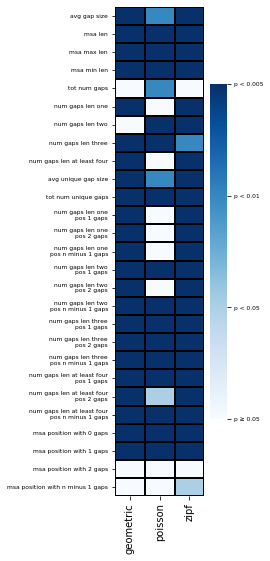

In [23]:
# ranges_adequacy = [(2.5,97.5),(0.5,99.5),(0.25, 99.75)]
# def check_interval(length_dist):
#     rows_filter = all_sims_data['length_distribution'] == length_dist
#     rows_to_check = all_sims_data[rows_filter]
#     rows_to_check = rows_to_check[SUMSTATS_LIST]

#     check_count = pd.Series(index=SUMSTATS_LIST, data=[0]*len(SUMSTATS_LIST),dtype=int)
#     for left_lim, right_lim in ranges_adequacy:
#         left_check = rows_to_check.quantile(left_lim/100) < empirical_sum_stats
#         right_check = rows_to_check.quantile(right_lim/100) > empirical_sum_stats
#         check_count = check_count + (left_check & right_check).astype(int)
#     check_count.name = length_dist
#     return check_count
# adequacy_summary = pd.concat([check_interval(dist) for dist in length_distributions], axis=1)

# adequacy_summary.index = [" ".join(stat_def.split('_')).lower() for stat_def in SUMSTATS_DEFINITION.values()]

# fig = plt.figure(figsize = (2,9))

# ax = sns.heatmap(adequacy_summary, cmap="Blues", linewidths=2, linecolor='black')
# ax.set_yticklabels(ax.get_yticklabels(), size = 6)
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 1, 2, 3])
# cbar.set_ticklabels(['p ≥ 0.05', 'p < 0.05', 'p < 0.01', 'p < 0.005'], size = 6)
# plt.show()


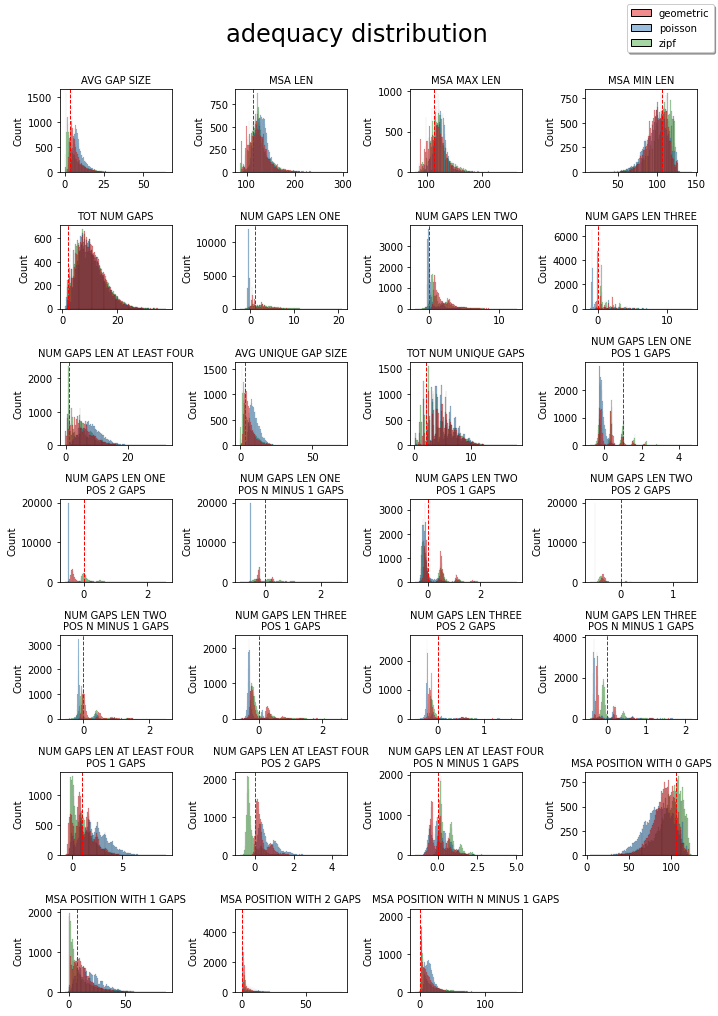

In [24]:
# sns.set_palette("Set1", 3)
# fig = plt.figure(figsize=(10, np.sqrt(2)*10))
# plt.suptitle(f"adequacy distribution\n", size=24)
# for current_stat in range(27):
#     empirical_x = empirical_sum_stats[current_stat]

#     x_min = all_sims_data[f"SS_{current_stat}"].min()
#     x_max = all_sims_data[f"SS_{current_stat}"].max()
#     x_min = x_min if x_min < empirical_x else empirical_x
#     x_max = x_max if x_max > empirical_x else empirical_x
#     x_offset =  5*np.abs(x_max-x_min)/100

#     ax = plt.subplot(7,4, current_stat+1)
#     sns.histplot(data=all_sims_data, 
#                  x=f"SS_{current_stat}",
#                  ax=ax,
#                  hue="length_distribution",
#                 #  element="step",
#                 #  fill=False,
#                  legend = False if current_stat < 26 else True)
#     plt.xlabel('')
#     plt.title(" ".join(SUMSTATS_DEFINITION[f"SS_{current_stat}"].split("_")), size=10)

#     plt.axvline(x=empirical_sum_stats[current_stat], linewidth=1, color='r', linestyle='--')
#     plt.xlim(x_min-x_offset, x_max+x_offset)


# legend = ax.get_legend()
# handles = legend.legendHandles
# legend.remove()
# fig.legend(handles, length_distributions, loc='upper right', fontsize=10, shadow=True)

# plt.tight_layout()
# # plt.savefig(join_path(f"adequacy.png"), dpi=300)
# # plt.close()
# plt.show()

In [25]:
# adequacy_summary
# p_vals = [1, 0.05, 0.01, 0.005]
# def convert_to_pvals(x):
#     return x.apply(lambda y: p_vals[y])

# p_val_summary = adequacy_summary.apply(convert_to_pvals, axis=1)
# p_val_summary.sum()

geometric    4.115
poisson      8.155
zipf         2.175
dtype: float64

In [30]:
current_data = "eggnog"

PearsonRResult(statistic=-0.027869537530945267, pvalue=0.5722308700891782)
           max_gap  match_percent  sum_branch_lengths    inv_prop  gamma_shape
count   413.000000     413.000000          413.000000  413.000000   413.000000
mean    622.244552       0.506032            3.761284    0.148489     2.304992
std     613.398064       0.212513            2.544126    0.126660     8.867729
min       5.000000       0.000000            1.002669    0.000000     0.332173
25%      94.000000       0.352941            1.744869    0.039425     0.831806
50%     517.000000       0.526316            3.234361    0.124284     1.111572
75%     920.000000       0.666667            4.968945    0.244632     1.629650
max    4030.000000       1.000000           18.106846    0.650440    99.852617


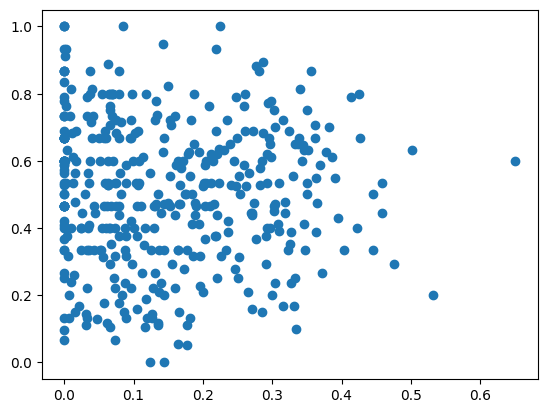

In [31]:
print(stats.pearsonr(adequacy_data[current_data].inv_prop,adequacy_data[current_data].match_percent))
print(adequacy_data[current_data].describe())
plt.scatter(adequacy_data[current_data].inv_prop, adequacy_data[current_data].match_percent)
plt.show()

PearsonRResult(statistic=0.04113628018641597, pvalue=0.40438962357735625)
           max_gap  match_percent  sum_branch_lengths    inv_prop  gamma_shape
count   413.000000     413.000000          413.000000  413.000000   413.000000
mean    622.244552       0.506032            3.761284    0.148489     2.304992
std     613.398064       0.212513            2.544126    0.126660     8.867729
min       5.000000       0.000000            1.002669    0.000000     0.332173
25%      94.000000       0.352941            1.744869    0.039425     0.831806
50%     517.000000       0.526316            3.234361    0.124284     1.111572
75%     920.000000       0.666667            4.968945    0.244632     1.629650
max    4030.000000       1.000000           18.106846    0.650440    99.852617


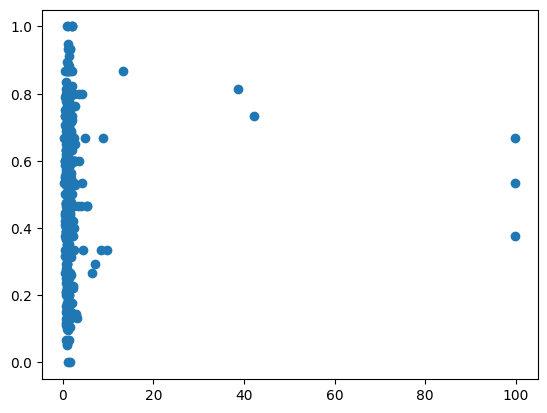

In [32]:
gamma_data = adequacy_data[current_data][adequacy_data[current_data].gamma_shape < 120]
print(stats.pearsonr(gamma_data.gamma_shape,gamma_data.match_percent))
print(gamma_data.describe())
plt.scatter(gamma_data.gamma_shape, gamma_data.match_percent)
plt.show()